# pytorch neurons and layers implementation

**Final Value Class Code**

In [1]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

### Neuron Class Implementation

    Input to nuron: x0, x1, x2
    
    Weight of neuron: w1, w2, w3 
    Bias of Neuron: b0, b1, b2
    Activation of Neuron: f
    
    Final equation: y = f(w*x + b)

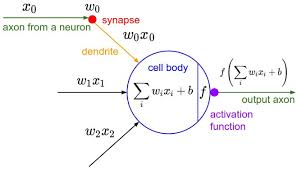

In [ ]:
#### Version1:

In [2]:
# neuron class
import random

class Neuron:
  # nin : no of input to the neuron
  # create w wrt each input
  # create baise wrt each neuron
  def __init__(self, nin):
    self.nin = nin
    self.w = [random.uniform(-1,1) for _ in range(nin)]
    self.b = random.uniform(-1,1)

  def __repr__(self) -> str:
    return f"Neuron(input_dim: {self.nin})"

  def __call__(self, x):
    # fun will retrun w*x + b
    return 0.0



x = [2.0,3.0]  # x: input of dim 2
n = Neuron(2)  # Neuron of dim = 2 dimintion ---> no of inputs to single neuron
print(n)
print(n(x))

Neuron(input_dim: 2)
0.0


In [ ]:
#### Version2:

In [6]:
## version 2:
# nuron class:
import random
import math

class Neuron:
    # single neuron which can hv multiple inputs
    # nin: no of input to the neuron
    def __init__(self, nin):
        # create w wrt to each input
        # create a baise b for the nuron
        self.nin = nin
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b  = Value(random.uniform(-1,1))

    def __repr__(self) -> str:
        return f"Neuron(input_dim = {self.nin})"

    def __call__(self, x):
        # fun will retrun w*x + b
        # 1st calculate w*x
        #act = (w*xi for w,xi in zip(self.w, x)) + self.b
        act = sum((w*xi for w,xi in zip(self.w, x)) , self.b)
        # activation function
        # out = f(w*x +b)
        out = act.tanh()
        return out



x = [2.0,3.0]  # x: input of dim 2
n = Neuron(2)  # Neuron of dim = 2 dimintion ---> no of inputs to single neuron
print(n)
print(n(x))


Neuron(input_dim = 2)
Value(data=0.9998988223595234)


### Linear Layer Class Implementation:

    nin: Num of inputs to each neuron in the layer = Num of inputs
    nout: Num of outputs in a perticular layer = Num of neurons in the layers

in the below figure its Multi Layer NN. 

    Input Layer:
        inputs: 2
    Hidden Layer :
        nin: 2
        nout: 3 = (num of neurons)
    Output Layer:
        nin: 3
        nout: 2 = (num of neurons)

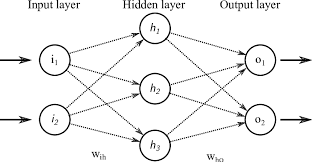

In [ ]:
#### Version3:

In [3]:
# version 3 :  layer of neurons:

## version 2:
# nuron class:
import random
import math

class Neuron:
    # single neuron which can hv multiple inputs
    # nin: no of input to the neuron
    def __init__(self, nin):
        # create w wrt to each input
        # create a baise b for the nuron
        self.nin = nin
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b  = Value(random.uniform(-1,1))

    def __repr__(self) -> str:
        return f"Neuron(input_dim = {self.nin})"

    def __call__(self, x):
        # x is the input
        # fun will retrun w*x + b
        # 1st calculate w*x
        #act = sum(w*xi for w,xi in zip(self.w, x)) + self.b
        act = sum((w*xi for w,xi in zip(self.w, x)) , self.b)
        # activation function
        # out = f(w*x +b)
        out = act.tanh()
        return out

# single layer
class Layer:
    def __init__(self, nin, nout):
        # nin: no of inputs to each neuron in the layer
        # no of outputs in a perticular layer (which is the no of neuron in the layers)
        self.nout = nout
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __repr__(self) -> str:
        return f"Layer(nout = {self.nout})"

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs




x = [2.0,3.0]  # x: input vector of dim 2
n = Layer(2, 3)  # 2: no of input to each neuron, 3: no of output (no of neuron in layer )
print(n)
print(n(x))


Layer(nout = 3)
[Value(data=0.8144913748874651), Value(data=-0.9912756873034018), Value(data=-0.856786911615369)]


In [ ]:
### MLP implimentation

In [ ]:
#### Version4: 

In [4]:
# version 4: MLP implimentation

# version 3 :  layer of neurons:

## version 2:
# nuron class:
import random
import math

class Neuron:
    # single neuron which can hv multiple inputs
    # nin: no of input to the neuron
    def __init__(self, nin):
        # create w wrt to each input
        # create a baise b for the nuron
        self.nin = nin
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b  = Value(random.uniform(-1,1))

    def __repr__(self) -> str:
        return f"Neuron(input_dim = {self.nin})"

    def __call__(self, x):
        # x is the input
        # fun will retrun w*x + b
        # 1st calculate w*x
        #act = sum(w*xi for w,xi in zip(self.w, x)) + self.b
        act = sum((w*xi for w,xi in zip(self.w, x)) , self.b)
        # activation function
        # out = f(w*x +b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        # nin: no of inputs to each neuron in the layer
        # no of outputs in a perticular layer (which is the no of neuron in the layers)
        self.nout = nout
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __repr__(self) -> str:
        return f"Layer(out = {self.nout})"

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

class MLP:
    def __init__(self, nin, nouts):
        # nin: no of inputs to each neuron in the layer
        # nouts: no of layers of neurons
        self.nouts = nouts
        sz = [nin] + nouts   # [3] + [4,4,1] = [3, 4, 4, 1]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __repr__(self) -> str:
        return f"MLP(output = {self.nouts[-1]})"

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x




x = [2.0, 3.0, -1.0]  # x: input vector of dim 3
n = MLP(3,[4,4,1])  # 3: no of input to each neuron,
                    # [4,4,1]: (no of layers of neurons = 3)
                    # layer 1: 4 neurons
                    # layer 2: 4 neurons
                    # layer 3: 1 neuron
print(n)
print(n(x))


MLP(output = 1)
[Value(data=-0.4278503915592869)]


In [ ]:
#### Version7: 

In [5]:
# version : 7
# version 4: MLP implimentation

# version 3 :  layer of neurons:

## version 2:
# nuron class:
import random
import math

class Neuron:
    # single neuron which can hv multiple inputs
    # nin: no of input to the neuron
    def __init__(self, nin):
        # create w wrt to each input
        # create a baise b for the nuron
        self.nin = nin
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b  = Value(random.uniform(-1,1))

    def __repr__(self) -> str:
        return f"Neuron(input_dim = {self.nin})"

    def __call__(self, x):
        # x is the input
        # fun will retrun w*x + b
        # 1st calculate w*x
        #act = sum(w*xi for w,xi in zip(self.w, x)) + self.b
        act = sum((w*xi for w,xi in zip(self.w, x)) , self.b)
        # activation function
        # out = f(w*x +b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        # nin: no of inputs to each neuron in the layer
        # no of outputs in a perticular layer (which is the no of neuron in the layers)
        self.nout = nout
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __repr__(self) -> str:
        return f"Layer(out = {self.nout})"

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        # nin: no of inputs to each neuron in the layer
        # nouts: no of layers of neurons
        self.nouts = nouts
        sz = [nin] + nouts   # [3] + [4,4,1] = [3, 4, 4, 1]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __repr__(self) -> str:
        return f"MLP(output = {self.nouts[-1]})"

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x




x = [2.0, 3.0, -1.0]  # x: input vector of dim 3
n = MLP(3,[4,4,1])  # 3: no of input to each neuron,
                    # [4,4,1]: (no of layers of neurons = 3)
                    # layer 1: 4 neurons
                    # layer 2: 4 neurons
                    # layer 3: 1 neuron
print(n)
print(n(x))


MLP(output = 1)
Value(data=-0.2059457169806532)


### Classifier implementation:

    # problem statement: implement classifier
    # xs : input matrix having input vectors
    # ys : true value wrt to each input vector.

In [6]:
# problem statement: implement classifier
# xs : input matrix having input vectors
# ys : true value wrt to each input vector.

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


import pandas as pd
df = pd.DataFrame()

df['Input Vector'] = xs
df['True_Output'] = ys
df

,Input Vector,True_Output
0,"[2.0, 3.0, -1.0]",1.0
1,"[3.0, -1.0, 0.5]",-1.0
2,"[0.5, 1.0, 1.0]",-1.0
3,"[1.0, 1.0, -1.0]",1.0


In [7]:
n = MLP(3,[4,4,1])  # 3: no of input to each neuron,
                    # [4,4,1]: (no of layers of neurons = 3)
                    # layer 1: 4 neurons
                    # layer 2: 4 neurons
                    # layer 3: 1 neuron

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.21047629751877886),
 Value(data=0.7771543836058495),
 Value(data=0.7616411179205261),
 Value(data=-0.027195752948343276)]

In [8]:
ypredd = [y.data for y in ypred]
df['Pred_Output'] = ypredd
df

,Input Vector,True_Output,Pred_Output
0,"[2.0, 3.0, -1.0]",1.0,-0.210476
1,"[3.0, -1.0, 0.5]",-1.0,0.777154
2,"[0.5, 1.0, 1.0]",-1.0,0.761641
3,"[1.0, 1.0, -1.0]",1.0,-0.027196


    our task is to tune these numbers in the Pred_Output such that the values will be near to
    the corrosponding Output value. ex: 0.90815 ----> move towards 1.0 desired target

In [10]:


# mean squared loss:
[(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]

# forward pass:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
print(loss)

# now will do backpropagation:
loss.backward()
print(n.layers[0].neurons[0].w[0].grad)


Value(data=8.782041113247654)
-4.838643463856296


    for this weight in the 1st layer of the MLP the gradiant is 1.93 ( +ive) which means
    if we decrease the weight by some amount the Loss will get decrease
    dely/delx  = grad
    dely = grad * delx
    if grad is +ive
    # dely = +ive * delx(increased)-----------> will increase the dely

In [ ]:
#### version : 8

In [11]:
# version : 8 add parameter function inside nueron class

# version 4: MLP implimentation

# version 3 :  layer of neurons:

## version 2:
# nuron class:
import random
import math

class Neuron:
    # single neuron which can hv multiple inputs
    # nin: no of input to the neuron
    def __init__(self, nin):
        # create w wrt to each input
        # create a baise b for the nuron
        self.nin = nin
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b  = Value(random.uniform(-1,1))

    def __repr__(self) -> str:
        return f"Neuron(input_dim = {self.nin})"

    def __call__(self, x):
        # x is the input
        # fun will retrun w*x + b
        # 1st calculate w*x
        #act = sum(w*xi for w,xi in zip(self.w, x)) + self.b
        act = sum((w*xi for w,xi in zip(self.w, x)) , self.b)
        # activation function
        # out = f(w*x +b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        # nin: no of inputs to each neuron in the layer
        # no of outputs in a perticular layer (which is the no of neuron in the layers)
        self.nout = nout
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __repr__(self) -> str:
        return f"Layer(out = {self.nout})"

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)

        return params


class MLP:
    def __init__(self, nin, nouts):
        # nin: no of inputs to each neuron in the layer
        # nouts: no of layers of neurons
        self.nouts = nouts
        sz = [nin] + nouts   # [3] + [4,4,1] = [3, 4, 4, 1]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __repr__(self) -> str:
        return f"MLP(output = {self.nouts[-1]})"

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]





x = [2.0, 3.0, -1.0]  # x: input vector of dim 3
n = MLP(3,[4,4,1])  # 3: no of input to each neuron,
                    # [4,4,1]: (no of layers of neurons = 3)
                    # layer 1: 4 neurons
                    # layer 2: 4 neurons
                    # layer 3: 1 neuron
print(n)
print(n(x))
print(n.parameters())
print(f"no of params: {len(n.parameters())}")
n.parameters()


MLP(output = 1)
Value(data=-0.8505262507606731)
[Value(data=0.46123570729523755), Value(data=0.9760553677385662), Value(data=0.614765287729415), Value(data=-0.2365226642604994), Value(data=0.2424548809366276), Value(data=-0.8533886740714729), Value(data=0.3270832084427371), Value(data=-0.689257228704901), Value(data=0.06904932594972357), Value(data=-0.2031866353523808), Value(data=-0.40205474547830056), Value(data=0.32311179102978516), Value(data=-0.360908018138155), Value(data=0.7271789718902713), Value(data=0.38594677675025535), Value(data=0.1807228102604066), Value(data=0.29814455475994706), Value(data=0.06942348962769107), Value(data=-0.48006962331175695), Value(data=-0.4285248925791558), Value(data=0.29535806800033804), Value(data=-0.30226727164663725), Value(data=0.6965800284884409), Value(data=-0.07968782275198572), Value(data=0.036689203668672565), Value(data=-0.807385339423655), Value(data=0.08762469559117392), Value(data=-0.6652576023360384), Value(data=-0.3847026981030939), 

[Value(data=0.46123570729523755),
 Value(data=0.9760553677385662),
 Value(data=0.614765287729415),
 Value(data=-0.2365226642604994),
 Value(data=0.2424548809366276),
 Value(data=-0.8533886740714729),
 Value(data=0.3270832084427371),
 Value(data=-0.689257228704901),
 Value(data=0.06904932594972357),
 Value(data=-0.2031866353523808),
 Value(data=-0.40205474547830056),
 Value(data=0.32311179102978516),
 Value(data=-0.360908018138155),
 Value(data=0.7271789718902713),
 Value(data=0.38594677675025535),
 Value(data=0.1807228102604066),
 Value(data=0.29814455475994706),
 Value(data=0.06942348962769107),
 Value(data=-0.48006962331175695),
 Value(data=-0.4285248925791558),
 Value(data=0.29535806800033804),
 Value(data=-0.30226727164663725),
 Value(data=0.6965800284884409),
 Value(data=-0.07968782275198572),
 Value(data=0.036689203668672565),
 Value(data=-0.807385339423655),
 Value(data=0.08762469559117392),
 Value(data=-0.6652576023360384),
 Value(data=-0.3847026981030939),
 Value(data=0.459106

In [12]:
# gradiant decent algorithm:
lr = 0.01
for p in n.parameters():
    p.data = p.data + -lr * p.grad


In [ ]:
### compete classifier with all the passes:

In [13]:
# problem statement: implement classifier
# xs : input matrix having input vectors
# ys : true value wrt to each input vector.

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


n = MLP(3,[4,4,1])  # 3: no of input to each neuron,
                    # [4,4,1]: (no of layers of neurons = 3)
                    # layer 1: 4 neurons
                    # layer 2: 4 neurons
                    # layer 3: 1 neuron


# forward pass:
ypred = [n(x) for x in xs]
print("before--->",ypred)
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
print(loss)

# now will do backpropagation:
# before backpropgration reset the gradiants to 0
for p in n.parameters():
    p.grad = 0.0
loss.backward()

# gradiant decent algorithm:
# weight update
lr = 0.01
for p in n.parameters():
    p.data = p.data + -lr * p.grad

print("after--->", ypred)

before---> [Value(data=-0.3770988783456924), Value(data=-0.784039649287889), Value(data=-0.06752932073214499), Value(data=0.17490166868324983)]
Value(data=3.4933290178566025)
after---> [Value(data=-0.3770988783456924), Value(data=-0.784039649287889), Value(data=-0.06752932073214499), Value(data=0.17490166868324983)]


In [2]:
# end!!!!!